<a href="https://colab.research.google.com/github/otokwala/Common-features/blob/main/Semi_supervised_learning_using_MQTT_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, scale
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
from numpy.random import seed
import tensorflow as tf
tf.random.set_seed(10)
from imblearn.over_sampling import SMOTE
import keras
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import csv
import h5py
from tensorflow import keras
import time
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import accuracy_score
from sys import getsizeof
from sklearn.metrics import classification_report
from sklearn.utils import shuffle

In [2]:
#!pip show pandas

Name: pandas
Version: 1.5.3
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: The Pandas Development Team
Author-email: pandas-dev@python.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, python-dateutil, pytz
Required-by: altair, arviz, bokeh, cmdstanpy, cufflinks, datascience, db-dtypes, dopamine-rl, fastai, geopandas, google-colab, gspread-dataframe, holoviews, mizani, mlxtend, pandas-datareader, pandas-gbq, panel, plotnine, prophet, pymc, seaborn, sklearn-pandas, statsmodels, vega-datasets, xarray, yfinance


In [3]:
pip install tensorflow-model-optimization

In [4]:
import tensorflow_model_optimization as tfmot

In [5]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

In [6]:
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

In [7]:
from google.colab import files

In [8]:
from google.colab import drive

In [9]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
data= pd.read_csv(r'/content/drive/MyDrive/Datasets/mqtt_data.csv')

In [11]:
# strip whitespace before and after column names
data.columns = data.columns.str.strip()

In [12]:
data.shape

(225711, 69)

In [13]:
data['Labels'].value_counts()

1    128025
0     97686
Name: Labels, dtype: int64

In [14]:
Labels=data['Labels'].tolist()

In [15]:
data1 = data.drop('Labels', axis=1)

In [16]:
# Find and replace NaNs with mean value
data1 = data1.fillna(data1.mean())

 # Find and replace infinities with finite values
data1.replace([np.inf, -np.inf], np.nan, inplace=True)
data1 = data1.fillna(data1.max())

In [17]:
data1=(data1-data1.min())/(data1.max()-data1.min())

In [18]:
data1.loc[:, data1.isna().any()]

""
0
1
2
3
4
...
225706
225707
225708
225709


In [19]:
#data1.drop('Fwd Avg Packets/Bulk', axis=1, inplace=True)

In [20]:
# sum total of NAN in dataset
nan_count = data1.isna().sum().sum()
print(nan_count )

0


In [21]:
def create_sequences(X, time_steps=5):
    Xs = []
    for i in range(0, len(X)-time_steps, 1):
        Xs.append(X.iloc[i:(i+time_steps)].values)

    return np.array(Xs)

In [22]:
X_train=create_sequences(data1)
X_train.shape

(225706, 5, 68)

In [23]:
# define the autoencoder network model
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
eL0 = LSTM(64, activation='tanh', return_sequences=True,
            recurrent_activation="sigmoid",
            kernel_initializer="glorot_uniform",
            recurrent_regularizer=regularizers.l2(0.0001),
            kernel_regularizer=regularizers.l2(0.0001))(inputs)
eL1 = LSTM(32, activation='tanh', return_sequences=True,
            recurrent_activation="sigmoid",
            kernel_initializer="glorot_uniform",
            recurrent_regularizer=regularizers.l2(0.0001),
            kernel_regularizer=regularizers.l2(0.0001))(eL0)
eL2 = LSTM(16, activation='tanh', return_sequences=True,
            recurrent_activation="sigmoid",
            kernel_initializer="glorot_uniform",
            recurrent_regularizer=regularizers.l2(0.0001),
            kernel_regularizer=regularizers.l2(0.0001))(eL1)
eL3 = LSTM(5, activation='tanh', return_sequences=False)(eL2)
h = RepeatVector(X_train.shape[1])(eL3)
dL2 = LSTM(16, activation='tanh', return_sequences=True)(h)
dL3 = LSTM(32, activation='tanh', return_sequences=True)(dL2)
dL4 = LSTM(64, activation='tanh', return_sequences=True)(dL3)
output = TimeDistributed(Dense(X_train.shape[2]))(dL4)
model = Model(inputs=inputs, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 68)]           0         
                                                                 
 lstm (LSTM)                 (None, 5, 64)             34048     
                                                                 
 lstm_1 (LSTM)               (None, 5, 32)             12416     
                                                                 
 lstm_2 (LSTM)               (None, 5, 16)             3136      
                                                                 
 lstm_3 (LSTM)               (None, 5)                 440       
                                                                 
 repeat_vector (RepeatVector  (None, 5, 5)             0         
 )                                                               
                                                             

Epoch 1/300
2822/2822 [==============================] - 123s 38ms/step - loss: 0.0179 - accuracy: 0.5528 - val_loss: 0.0125 - val_accuracy: 0.5689
Epoch 2/300
2822/2822 [==============================] - 104s 37ms/step - loss: 0.0087 - accuracy: 0.7714 - val_loss: 0.0102 - val_accuracy: 0.6114
Epoch 3/300
2822/2822 [==============================] - 103s 37ms/step - loss: 0.0074 - accuracy: 0.8023 - val_loss: 0.0090 - val_accuracy: 0.6263
Epoch 4/300
2822/2822 [==============================] - 102s 36ms/step - loss: 0.0067 - accuracy: 0.8074 - val_loss: 0.0087 - val_accuracy: 0.6352
Epoch 5/300
2822/2822 [==============================] - 102s 36ms/step - loss: 0.0063 - accuracy: 0.8136 - val_loss: 0.0086 - val_accuracy: 0.6600
Epoch 6/300
2822/2822 [==============================] - 99s 35ms/step - loss: 0.0061 - accuracy: 0.8169 - val_loss: 0.0081 - val_accuracy: 0.6732
Epoch 7/300
2822/2822 [==============================] - 105s 37ms/step - loss: 0.0059 - accuracy: 0.8204 - val_l

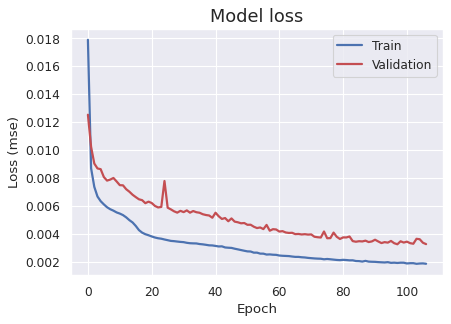

In [24]:
# fit the model to the data
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
nb_epochs = 300
batch_size = 64
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])
#model.compile(optimizer=opt, loss='log_cosh', metrics=['accuracy'])

history = model.fit(X_train, X_train,
                    epochs=nb_epochs,
                    batch_size=batch_size,
                    validation_split=0.2,
                    callbacks=[callback]
                    ).history



# plot the training losses
fig, ax = plt.subplots(figsize=(6, 4), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mse)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [25]:
encode = Model(inputs=inputs, outputs=model.layers[5].output)
output_encoder = encode.predict(X_train[:])

7054/7054 [==============================] - 42s 6ms/step


In [26]:
len(output_encoder)

225706

In [27]:
outputs =[]
for i in output_encoder:
    arr = i[4].tolist()
    outputs.append(arr)

In [28]:
len(outputs)

225706

In [29]:
df = pd.DataFrame(outputs)

In [30]:
Labels = Labels[:-5]

In [31]:
len(Labels)

225706

In [32]:
df['Labels']=Labels
df.shape

(225706, 6)

In [33]:
df['Labels'].unique()

array([0, 1])

In [34]:
encoded=df

In [35]:
encoded.columns=['V1','V2','V3','V4','V5','Labels']

In [36]:
encoded['Labels'].value_counts()

1    128025
0     97681
Name: Labels, dtype: int64

In [37]:
y = encoded[['Labels']]
X = encoded.drop(['Labels'], axis=1)

In [38]:
y.shape, X.shape

((225706, 1), (225706, 5))

In [39]:
X_labeled, X_unlabeled, y_labeled, _ = train_test_split(X, y, test_size=0.5, random_state=42)

In [40]:
from sklearn.preprocessing import LabelEncoder

In [41]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

In [42]:
# Fit and transform the labels
encoded_labels = label_encoder.fit_transform(y_labeled)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [43]:
# Get the number of classes
num_classes = len(label_encoder.classes_)

In [44]:
print(encoded_labels[0:5])

[1 1 1 0 0]


In [45]:
# Convert to one-hot encoding
#labeled_labels_onehot = tf.keras.utils.to_categorical(encoded_labels, num_classes)
labeled_labels_onehot = encoded_labels.reshape(-1, 1)

In [46]:
print(labeled_labels_onehot[0:5])

[[1]
 [1]
 [1]
 [0]
 [0]]


In [47]:
# Split the data into labeled and unlabeled examples
# labeled_data, unlabeled_data, labeled_labels, _ = train_test_split(data, labels, test_size=0.5, stratify=labels)

In [48]:
X_labeled.shape

(112853, 5)

In [49]:
X_unlabeled.shape

(112853, 5)

In [50]:
y_labeled.shape

(112853, 1)

In [51]:
labeled_labels_onehot.shape

(112853, 1)

In [52]:
# Define the model architecture
model = Sequential()
model.add(Dense(12, input_shape=(5,), activation='relu'))
model.add(Dense(2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [53]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [54]:
# Train the model
model.fit(X_labeled, labeled_labels_onehot, epochs=200)

Epoch 1/200
3527/3527 [==============================] - 8s 2ms/step - loss: 0.1589 - accuracy: 0.9543
Epoch 2/200
3527/3527 [==============================] - 8s 2ms/step - loss: 0.0385 - accuracy: 0.9902
Epoch 3/200
3527/3527 [==============================] - 7s 2ms/step - loss: 0.0274 - accuracy: 0.9922
Epoch 4/200
3527/3527 [==============================] - 8s 2ms/step - loss: 0.0232 - accuracy: 0.9934
Epoch 5/200
3527/3527 [==============================] - 7s 2ms/step - loss: 0.0213 - accuracy: 0.9939
Epoch 6/200
3527/3527 [==============================] - 8s 2ms/step - loss: 0.0201 - accuracy: 0.9944
Epoch 7/200
3527/3527 [==============================] - 7s 2ms/step - loss: 0.0195 - accuracy: 0.9945
Epoch 8/200
3527/3527 [==============================] - 8s 2ms/step - loss: 0.0190 - accuracy: 0.9947
Epoch 9/200
3527/3527 [==============================] - 7s 2ms/step - loss: 0.0187 - accuracy: 0.9948
Epoch 10/200
3527/3527 [==============================] - 8s 2ms/step - l

In [55]:
# Save the trained model
model.save('nbw_model.h5')

In [56]:
# Convert the Keras model to a TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [57]:
# Save the TensorFlow Lite model to a file
with open('nbw_model.tflite', 'wb') as f:
    f.write(tflite_model)

In [58]:
# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path='nbw_model.tflite')
interpreter.allocate_tensors()

In [59]:
# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input shape:", input_details[0]["shape"])
print("Input type:", input_details[0]["dtype"])
print("Output shape:", output_details[0]["shape"])
print("Output type:", output_details[0]["dtype"])

Input shape: [1 5]
Input type: <class 'numpy.float32'>
Output shape: [1 1]
Output type: <class 'numpy.float32'>


In [60]:
# resize the shape
interpreter.resize_tensor_input(input_details[0]['index'], (112853, 5))
interpreter.resize_tensor_input(output_details[0]['index'], (112853, 1))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [61]:
unlabeled_data_for_inference = np.array(X_unlabeled, dtype=np.float32)

In [62]:
# Perform inference on the unlabeled data
interpreter.set_tensor(input_details[0]['index'], unlabeled_data_for_inference)
interpreter.invoke()
predicted_labels_onehot = interpreter.get_tensor(output_details[0]['index'])

In [63]:
# Extract the predicted labels
predicted_labels = np.argmax(predicted_labels_onehot, axis=1)

In [64]:
# Add confident predictions to the labeled data (same as before)
confident_mask = np.amax(predicted_labels_onehot, axis=1) > 0.9
confident_data = X_unlabeled[confident_mask]
confident_labels = predicted_labels[confident_mask]
labeled_data = np.concatenate([X_labeled, confident_data])

In [69]:
# Reshape confident_labels separately
confident_labels_onehot = confident_labels.reshape(-1, 1)

In [70]:
confident_labels_onehot_reshape = confident_labels_onehot[:, 0].reshape(-1, 1)

In [71]:
# Concatenate labeled_labels_onehot and confident_labels_onehot
labeled_labels_onehot = np.concatenate([labeled_labels_onehot, confident_labels_onehot])

In [72]:
# Evaluate the model on the test data (same as before)
test_data, test_labels = shuffle(X, y)

In [73]:
label_encoder = LabelEncoder()
label_encoder.fit(test_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LabelEncoder()

In [74]:
encoded_labels = label_encoder.transform(test_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [75]:
test_labels_onehot = tf.keras.utils.to_categorical(encoded_labels, num_classes)

In [76]:
_, accuracy = model.evaluate(test_data, encoded_labels)

print(f'Test accuracy: {accuracy}')

7054/7054 [==============================] - 12s 2ms/step - loss: 0.0114 - accuracy: 0.9970
Test accuracy: 0.9969961047172546


In [77]:
# Generate classification report
predicted_labels = model.predict(test_data)

7054/7054 [==============================] - 10s 1ms/step


In [78]:
predicted_labels = np.round(predicted_labels).astype(int)

In [79]:
label_encoder = LabelEncoder()
encoded_true_labels = label_encoder.fit_transform(test_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [80]:
# Generate classification report
report = classification_report(encoded_true_labels, predicted_labels)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     97681
           1       1.00      1.00      1.00    128025

    accuracy                           1.00    225706
   macro avg       1.00      1.00      1.00    225706
weighted avg       1.00      1.00      1.00    225706



In [81]:
# Generate classification report
start_time = time.time()
report = classification_report(encoded_true_labels, predicted_labels)
stop_time = time.time()
print("validation time: ",(stop_time-start_time))
print(report)

validation time:  0.7163546085357666
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     97681
           1       1.00      1.00      1.00    128025

    accuracy                           1.00    225706
   macro avg       1.00      1.00      1.00    225706
weighted avg       1.00      1.00      1.00    225706



In [82]:
convert_bytes(get_file_size('nbw_model.tflite'), "MB")

File size: 0.002 Megabytes
